In [93]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import networkx as nx
import random
from tqdm import tqdm
from typing import List, Tuple
import numpy as np
import seaborn as sns

In [94]:
data=pd.read_csv('/srv/abacus-1/uniswapv2_TY_23/UniswapV2_daily_snapshot_sync_18012051_with_price.csv')
if data['price'].dtype != float:
    data['price'] = data['price'].astype(float)

/tmp/ipykernel_672146/4178084309.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/srv/abacus-1/uniswapv2_TY_23/UniswapV2_daily_snapshot_sync_18012051_with_price.csv')


In [132]:
sample_data = data[data['reserveUSD'] > 100]
sample_data

,block_number,timestamp,tx_hash,log_index,transactionIndex,token_contract_address,reserve0,reserve1,pair_contract_address1,createdAtBlockNumber,...,token0.name,token0.symbol,token1.decimals,token1.id,token1.name,token1.symbol,reserveUSD,reserve0_decimals,reserve1_decimals,price
4,17927387,2023-08-16T12:27:23,0x6f84f564f267faac5b4c378ce12838b696ab7650bc16...,34,6,0x0002b080a4378d0d6be8ff21a10f33d35ab20a8d,3303586905229376344282776953290,709547995426253925,0x0002b080a4378d0d6be8ff21a10f33d35ab20a8d,17206596.0,...,clown,CLOWN,18.0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,1294.695850,3.303587e+12,7.095480e-01,4.655903e+12
7,18009968,2023-08-28T01:49:47,0x5a385ab401f68a9e22a7cf7e88fa15980c83a53e5fac...,260,63,0x00030110a7053083a7a160449a0e8f1adce9438d,4148127836372883556692258,3748271657000564858,0x00030110a7053083a7a160449a0e8f1adce9438d,12625441.0,...,SoMee.Social,SOMEE,18.0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,11454.501882,4.148128e+06,3.748272e+00,1.106677e+06
15,17399238,2023-06-03T09:22:11,0xc7d547b6beb6af0060e44d81563f5e2d2a4a8da1eecf...,92,34,0x00048cf1acdb5fa81a0facf869ef60c3f49bfe36,14215448493616681140285503,58537685321465884,0x00048cf1acdb5fa81a0facf869ef60c3f49bfe36,10813698.0,...,CocktailToken,COCK,18.0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,111.574899,1.421545e+07,5.853769e-02,2.428427e+08
31,17707619,2023-07-16T18:26:11,0x38f90c1648f959a877d8551bef19487a1680187abc1f...,293,85,0x000bed7db93b8b86c69a5559f7374ee4c6ea7f4c,31767798042599840,630583803028589,0x000bed7db93b8b86c69a5559f7374ee4c6ea7f4c,17473940.0,...,Wrapped Ether,WETH,9.0,0xc78319def56b67d4e3a56df41bc1880e827797e4,DEV IS COOKING,COOK,123.198081,3.176780e-02,6.305838e+05,5.037839e-08
39,18007091,2023-08-27T16:08:23,0xe2390b1681a180795474cd75c93ce38f7cbb4f39949f...,185,78,0x000dd0b1528a396c6ea2e09796a7b4a534e9e37b,25250199262910743554,99030013737877065188665188,0x000dd0b1528a396c6ea2e09796a7b4a534e9e37b,12408218.0,...,Wrapped Ether,WETH,18.0,0xc8807f0f5ba3fa45ffbdc66928d71c5289249014,Ispolink Token,ISP,158091.448982,2.525020e+01,9.903001e+07,2.549752e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233969,17552399,2023-06-24T22:39:35,0xfefaaef77078fdca1f76e225ee6e50836ebe029144c4...,65,28,0xffedea4f0ecbbf255880ca1d424b2f30f6da7afc,298924196503203214804425,323994086210175188,0xffedea4f0ecbbf255880ca1d424b2f30f6da7afc,11154577.0,...,starlink.finance,STAR,18.0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,607.778549,2.989242e+05,3.239941e-01,9.226224e+05
233992,17986692,2023-08-24T19:38:11,0xd54dba45f28a0c84d203c518dbd9a66a23e43823a850...,44,4,0xfff475e8fde7380a9a29a6441b832353337b094e,58330160527,26127440787935121566,0xfff475e8fde7380a9a29a6441b832353337b094e,11334836.0,...,BTSE Token,BTSE,18.0,0xb753428af26e81097e7fd17f40c88aaa3e04902c,Spice,SFI,1259.216700,5.833016e+02,2.612744e+01,2.232525e+01
233997,17436270,2023-06-08T14:47:35,0x3ac333159f32d8682ed02bbb95e1a3498ec62821e34f...,244,94,0xfff5a9b956510faa986c0536b761979815adda53,1518699641794083351142,1346808466404989789,0xfff5a9b956510faa986c0536b761979815adda53,11518558.0,...,Infinitus,Inf,18.0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,4294.947608,1.518700e+03,1.346808e+00,1.127629e+03
234009,16975177,2023-04-04T11:16:47,0x144200375d13068d8f6749a71935e3c74c4bbf171d0f...,28,5,0xfff8000aa3ce967d854a63464ffd6e95a01af92a,2288377968473448053,863220063776938168070855517398725,0xfff8000aa3ce967d854a63464ffd6e95a01af92a,15402284.0,...,Wrapped Ether,WETH,18.0,0xe71b8f912841e473b05bfcbd7394755d917d0d28,Yakimoki,The Unknown Truth,8541.222471,2.288378e+00,8.632201e+14,2.650979e-15


In [133]:
sorted_data = sample_data.sort_values(by='reserveUSD', ascending=False).head(5)
top_5_token_ids = sorted_data['token0.id'].tolist()
top_5_token_ids

['0x395c8db957d743a62ac3aaaa4574553bcf2380b3',
 '0x66a0f676479cee1d7373f3dc2e2952778bff5bd6',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
 '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
 '0x6b175474e89094c44da98b954eedeac495271d0f']

In [134]:
# Update the network creation function to ensure reserve data is in float type
def create_network_with_float_constraints(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        # Convert reserves to float
        reserve0 = float(row['reserve0'])
        reserve1 = float(row['reserve1'])

        # Add vertices (tokens)
        G.add_node(row['token0.id'])
        G.add_node(row['token1.id'])

        # Add an edge from token0 to token1 with price and additional attributes
        forward_edge_attributes = {
            'price': row['price'],
            'reserve': reserve1,  # reserve of token1 for token0 to token1 edge
            'block_number': row['block_number'],
            'transactionIndex': row['transactionIndex'],
            'log_index': row['log_index']
        } 
        G.add_edge(row['token0.id'], row['token1.id'], **forward_edge_attributes)

        # Add the reverse edge from token1 to token0 with the inverse price
        reverse_edge_attributes = {
            'price': 1 / row['price'] if row['price'] != 0 else 0,
            'reserve': reserve0,  # reserve of token0 for token1 to token0 edge
            'block_number': row['block_number'],
            'transactionIndex': row['transactionIndex'],
            'log_index': row['log_index']
        }
        G.add_edge(row['token1.id'], row['token0.id'], **reverse_edge_attributes)

    return G

In [135]:
G_sample = create_network_with_float_constraints(sample_data)

In [136]:
def find_cycles_classified_by_length(G: nx.DiGraph, start_node: str, max_depth=10) -> dict:
    """
    Find all true cycles starting and ending with the given node in a directed graph,
    and classify them by their length.

    :param G: Directed graph
    :param start_node: Node to start and end cycles
    :param max_depth: Maximum depth to search to prevent deep recursion
    :return: Dictionary with keys as cycle lengths and values as lists of cycles of that length
    """
    cycles_by_length = {}

    def dfs(current_node, visited, path, depth):
        """
        Depth-first search to find and classify cycles by length.

        :param current_node: Current node being visited
        :param visited: Set of visited nodes in the current path
        :param path: Current path of nodes
        :param depth: Current depth of recursion
        """
        if depth > max_depth:
            # Max depth reached, return to prevent infinite recursion
            return

        # Add current node to visited set and path
        visited.add(current_node)
        path.append(current_node)

        for neighbor in G.successors(current_node):
            if neighbor == start_node and len(set(path)) > 2:  # Ensure true cycle with more than one edge
                cycle = tuple(path + [start_node])
                cycle_length = len(cycle)
                # Add cycle to the corresponding list by its length
                if cycle_length not in cycles_by_length:
                    cycles_by_length[cycle_length] = []
                cycles_by_length[cycle_length].append(cycle)
            elif neighbor not in visited:
                dfs(neighbor, visited.copy(), path.copy(), depth + 1)

    # Start DFS from the start node
    dfs(start_node, set(), [], 1)

    return cycles_by_length

# Note: This adapted function is designed for demonstration purposes.
# Please adjust the `max_depth` parameter based on your graph's size and complexity to avoid excessive recursion.


In [137]:
start_token0 = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
start_token1 = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
start_token2 = '0x6b175474e89094c44da98b954eedeac495271d0f'
start_token3 = '0xdac17f958d2ee523a2206206994597c13d831ec7'

In [140]:
# Find all true cycles starting and ending with the start_token, excluding simple back and forth paths
cycles_by_length0 = find_cycles_classified_by_length(G_sample, start_token0, max_depth=4) #max_depth = 10 using 879 seconds
cycles_by_length1 = find_cycles_classified_by_length(G_sample, start_token1, max_depth=4)
cycles_by_length2 = find_cycles_classified_by_length(G_sample, start_token2, max_depth=4)
cycles_by_length3 = find_cycles_classified_by_length(G_sample, start_token3, max_depth=4)

In [ ]:
cycles_by_length = find_cycles_classified_by_length(G_sample, start_token1, max_depth=10)

In [99]:
import csv
from tqdm import tqdm 
def batch_generator(data, batch_size=10000):
    batch = []
    for item in data:
        batch.append(item)
        if len(batch) >= batch_size:
            yield batch
            batch = []
    if batch:
        yield batch
def process_batch_with_details(batch, csv_writer, G):
    for path in batch:
        # Extract details for the current path
        path_details_list = extract_path_details(G, [path])
        for path_details in path_details_list:
            # Prepare row with addresses
            row = list(path_details['path']) + [None] * (10 - len(path_details['path']))
            # Append details
            row.extend([
                path_details['details']['block_number'],
                path_details['details']['transactionIndex'],
                path_details['details']['log_index']
            ])
            csv_writer.writerow(row)

# Example usage with your existing code
csv_file_path = 'cycles_by_length_with_details3-10_USDC.csv'
with open(csv_file_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)
    # Adjusted header with new columns for details
    csv_writer.writerow([f'Address{i+1}' for i in range(10)] + ['block_number', 'transactionIndex', 'log_index'])

    for length in [4, 5, 6, 7, 8, 9, 10]:
        if length in cycles_by_length:
            paths = cycles_by_length[length]
            total_batches = (len(paths) + 9999) // 10000  # Calculate total number of batches
            with tqdm(total=total_batches, desc=f"Processing paths of length {length}") as pbar:
                for batch in batch_generator(paths, batch_size=10000):
                    process_batch_with_details(batch, csv_writer, G_sample)  # Use the modified function
                    pbar.update(1)


Processing paths of length 8:  67%|██████▋   | 8/12 [00:01<00:00,  5.53it/s]


KeyboardInterrupt: 

In [ ]:
# Output the number of true cycles found and examples
num_true_cycles_found = sum(len(cycles) for cycles in cycles_by_length.values())
example_true_cycles = cycles_by_length if cycles_by_length else []
example_true_cycles = {length: list(set(cycles)) for length, cycles in example_true_cycles.items()}
num_true_cycles_found

In [141]:
def calculate_slippage_and_check_reserve(price, amount, reserve):
    """
    Calculate the slippage and check if the amount is within the liquidity reserve.
    :param price: The price of the token.
    :param amount: The amount to be traded.
    :param reserve: The liquidity reserve.
    :return: The adjusted price considering slippage and a boolean indicating if the reserve is sufficient.
    """
    # Assuming a slippage model where slippage increases with the square of the amount (to a power of 2)
    # This is a simple model and may not accurately represent all liquidity pool mechanisms.
    slippage = (amount / reserve)**2
    adjusted_price = price * (1 + slippage)
    reserve_sufficient = amount <= reserve
    return adjusted_price, reserve_sufficient

def calculate_arbitrage_amount(G, path, start_amount=1.0):
    """
    Calculate the arbitrage amount for a given path considering slippage and reserve checks.
    
    :param G: Directed graph from which to extract path details.
    :param path: The path for which to calculate the arbitrage amount.
    :return: Arbitrage amount considering slippage, or None if any reserve is insufficient.
    """
    amount = start_amount  # Start with 1 unit of the starting token
    for i in range(len(path) - 1):
        start_node = path[i]
        end_node = path[i + 1]
        edge_data = G.get_edge_data(start_node, end_node)
        price = edge_data['price']
        reserve = edge_data['reserve']
        
        # Calculate adjusted price with slippage and check reserve
        adjusted_price, reserve_sufficient = calculate_slippage_and_check_reserve(price, amount, reserve)
        
        if not reserve_sufficient:
            return None  # If reserve is not sufficient for any trade, return None to indicate failure
        
        amount *= adjusted_price  # Convert the amount through each adjusted price
    
    return amount - start_amount  # Subtract the initial 1 unit to get the arbitrage amount


def extract_path_details(G, paths):
    """
    Extract details for given paths from the graph G and calculate arbitrage amount for each path.

    :param G: Directed graph from which to extract path details and calculate arbitrage.
    :param paths: List of paths (each path is a tuple of node IDs).
    :return: List of dictionaries with path details including arbitrage amount.
    """
    path_details_list = []  # List to store details of all paths including arbitrage amount

    for path in paths:
        path_details = {
            'path': path,
            'arbitrage_amount': calculate_arbitrage_amount(G, path),
            'details': {
                'block_number': [],
                'transactionIndex': [],
                'log_index': []
            }
        }
        
        # Extract details for each edge in the path
        for i in range(len(path) - 1):
            start_node = path[i]
            end_node = path[i + 1]
            edge_data = G.get_edge_data(start_node, end_node)
            
            path_details['details']['block_number'].append(edge_data['block_number'])
            path_details['details']['transactionIndex'].append(edge_data['transactionIndex'])
            path_details['details']['log_index'].append(edge_data['log_index'])
        
        path_details_list.append(path_details)

    return path_details_list

In [142]:
def calculate_equivalent_start_token_reserve(G, path):
    """
    Calculate the equivalent reserve of the start token along a given path, considering
    the reserve and price of each token in the path.

    :param G: Directed graph containing the tokens and their exchange data.
    :param path: The path of token exchanges.
    :return: The equivalent reserve of the start token considering the entire path.
    """
    # Start with an empty list to keep track of the equivalent reserves
    equivalent_reserves = []
    
    # Iterate through each edge in the path to calculate the equivalent reserve
    for i in range(len(path) - 1):
        start_node = path[i]
        end_node = path[i + 1]
        
        # Get the exchange data for the current edge
        edge_data = G.get_edge_data(start_node, end_node)
        price = edge_data['price']  # Price to exchange start_node token for end_node token
        reserve = edge_data['reserve']  # Reserve of the end_node token
        
        # Calculate the equivalent reserve of the start token for this exchange
        # Assuming the price is defined as the amount of end_node token you get for one start_node token
        equivalent_reserve = reserve / price
        equivalent_reserves.append(equivalent_reserve)
    
    # The equivalent start token reserve is the minimum of all equivalent reserves
    # since the path's bottleneck determines the maximum amount that can be exchanged
    equivalent_start_token_reserve = min(equivalent_reserves) if equivalent_reserves else 0
    
    return equivalent_start_token_reserve


In [143]:
def process_cycles_with_slippage_and_reserve(G, cycles_by_length, length=None):
    """
    Process cycles to calculate arbitrage amounts considering slippage and equivalent start token reserve,
    optionally filtered by a specific cycle length.

    :param G: Directed graph containing token exchange data.
    :param cycles_by_length: Dictionary of cycles classified by their length.
    :param length: Specific length of cycles to process. If None, processes all lengths.
    :return: A dictionary with updated cycle details including arbitrage amounts and equivalent reserves.
    """
    processed_details = {}
    
    if length is not None and length in cycles_by_length:
        relevant_cycles = {length: cycles_by_length[length]}
    else:
        relevant_cycles = cycles_by_length

    for cycle_length, cycles in relevant_cycles.items():
        details_list = []
        for path in cycles:
            equivalent_reserve = calculate_equivalent_start_token_reserve(G, path)
            min_amount_for_arbitrage = min(1.0, equivalent_reserve)
            arbitrage_amount = calculate_arbitrage_amount(G, path, min_amount_for_arbitrage)
            
            if arbitrage_amount is not None and arbitrage_amount > 0:
                cycle_detail = {
                    'path': path,
                    'equivalent_start_token_reserve': equivalent_reserve,
                    'arbitrage_amount': arbitrage_amount,
                    'details': extract_path_details(G, [path])[0]['details']
                }
                details_list.append(cycle_detail)

        processed_details[cycle_length] = details_list

    return processed_details

In [144]:
processed_cycles0 = process_cycles_with_slippage_and_reserve(G_sample, cycles_by_length0, length=4)
processed_cycles1 = process_cycles_with_slippage_and_reserve(G_sample, cycles_by_length1, length=4)
processed_cycles2 = process_cycles_with_slippage_and_reserve(G_sample, cycles_by_length2, length=4)
processed_cycles3 = process_cycles_with_slippage_and_reserve(G_sample, cycles_by_length3, length=4)

In [145]:
# 统计满足条件的环路数量
num_profitable_cycles = len(profitable_cycles)
profitable_cycles = [cycle for cycle in processed_cycles[4] if cycle['arbitrage_amount'] > 0]
# 按照arbitrage_amount降序排序profitable_cycles
sorted_profitable_cycles = sorted(profitable_cycles, key=lambda x: x['arbitrage_amount'], reverse=True)
for cycle in sorted_profitable_cycles[:5]:  
    print(f"Path: {cycle['path']}, Arbitrage Amount: {cycle['arbitrage_amount']}")
print(num_profitable_cycles)

NameError: name 'profitable_cycles' is not defined

In [146]:
profitable_cycles0 = [cycle for cycle in processed_cycles0[4] if cycle['arbitrage_amount'] > 0]
profitable_cycles1 = [cycle for cycle in processed_cycles1[4] if cycle['arbitrage_amount'] > 0]
profitable_cycles2 = [cycle for cycle in processed_cycles2[4] if cycle['arbitrage_amount'] > 0]
profitable_cycles3 = [cycle for cycle in processed_cycles3[4] if cycle['arbitrage_amount'] > 0]
filtered_profitable_cycles0 = [cycle for cycle in profitable_cycles0 if cycle['arbitrage_amount'] < 0.5]
filtered_profitable_cycles1 = [cycle for cycle in profitable_cycles1 if cycle['arbitrage_amount'] < 0.5]
filtered_profitable_cycles2 = [cycle for cycle in profitable_cycles2 if cycle['arbitrage_amount'] < 0.5]
filtered_profitable_cycles3 = [cycle for cycle in profitable_cycles3 if cycle['arbitrage_amount'] < 0.5]

In [147]:
# 筛选出arbitrage_amount小于20的环路
filtered_profitable_cycles = [cycle for cycle in profitable_cycles if cycle['arbitrage_amount'] < 20]

# 统计满足条件的环路数量
num_filtered_profitable_cycles = len(filtered_profitable_cycles)

# 按照arbitrage_amount升序排序filtered_profitable_cycles
sorted_filtered_profitable_cycles = sorted(filtered_profitable_cycles, key=lambda x: x['arbitrage_amount'], reverse=True)

# 打印排序后的前5个环路的详细信息来验证排序结果
for cycle in sorted_filtered_profitable_cycles[:5]:  
    print(f"Path: {cycle['path']}, Arbitrage Amount: {cycle['arbitrage_amount']}")

# 打印满足条件的环路数量
print(num_filtered_profitable_cycles)

NameError: name 'profitable_cycles' is not defined

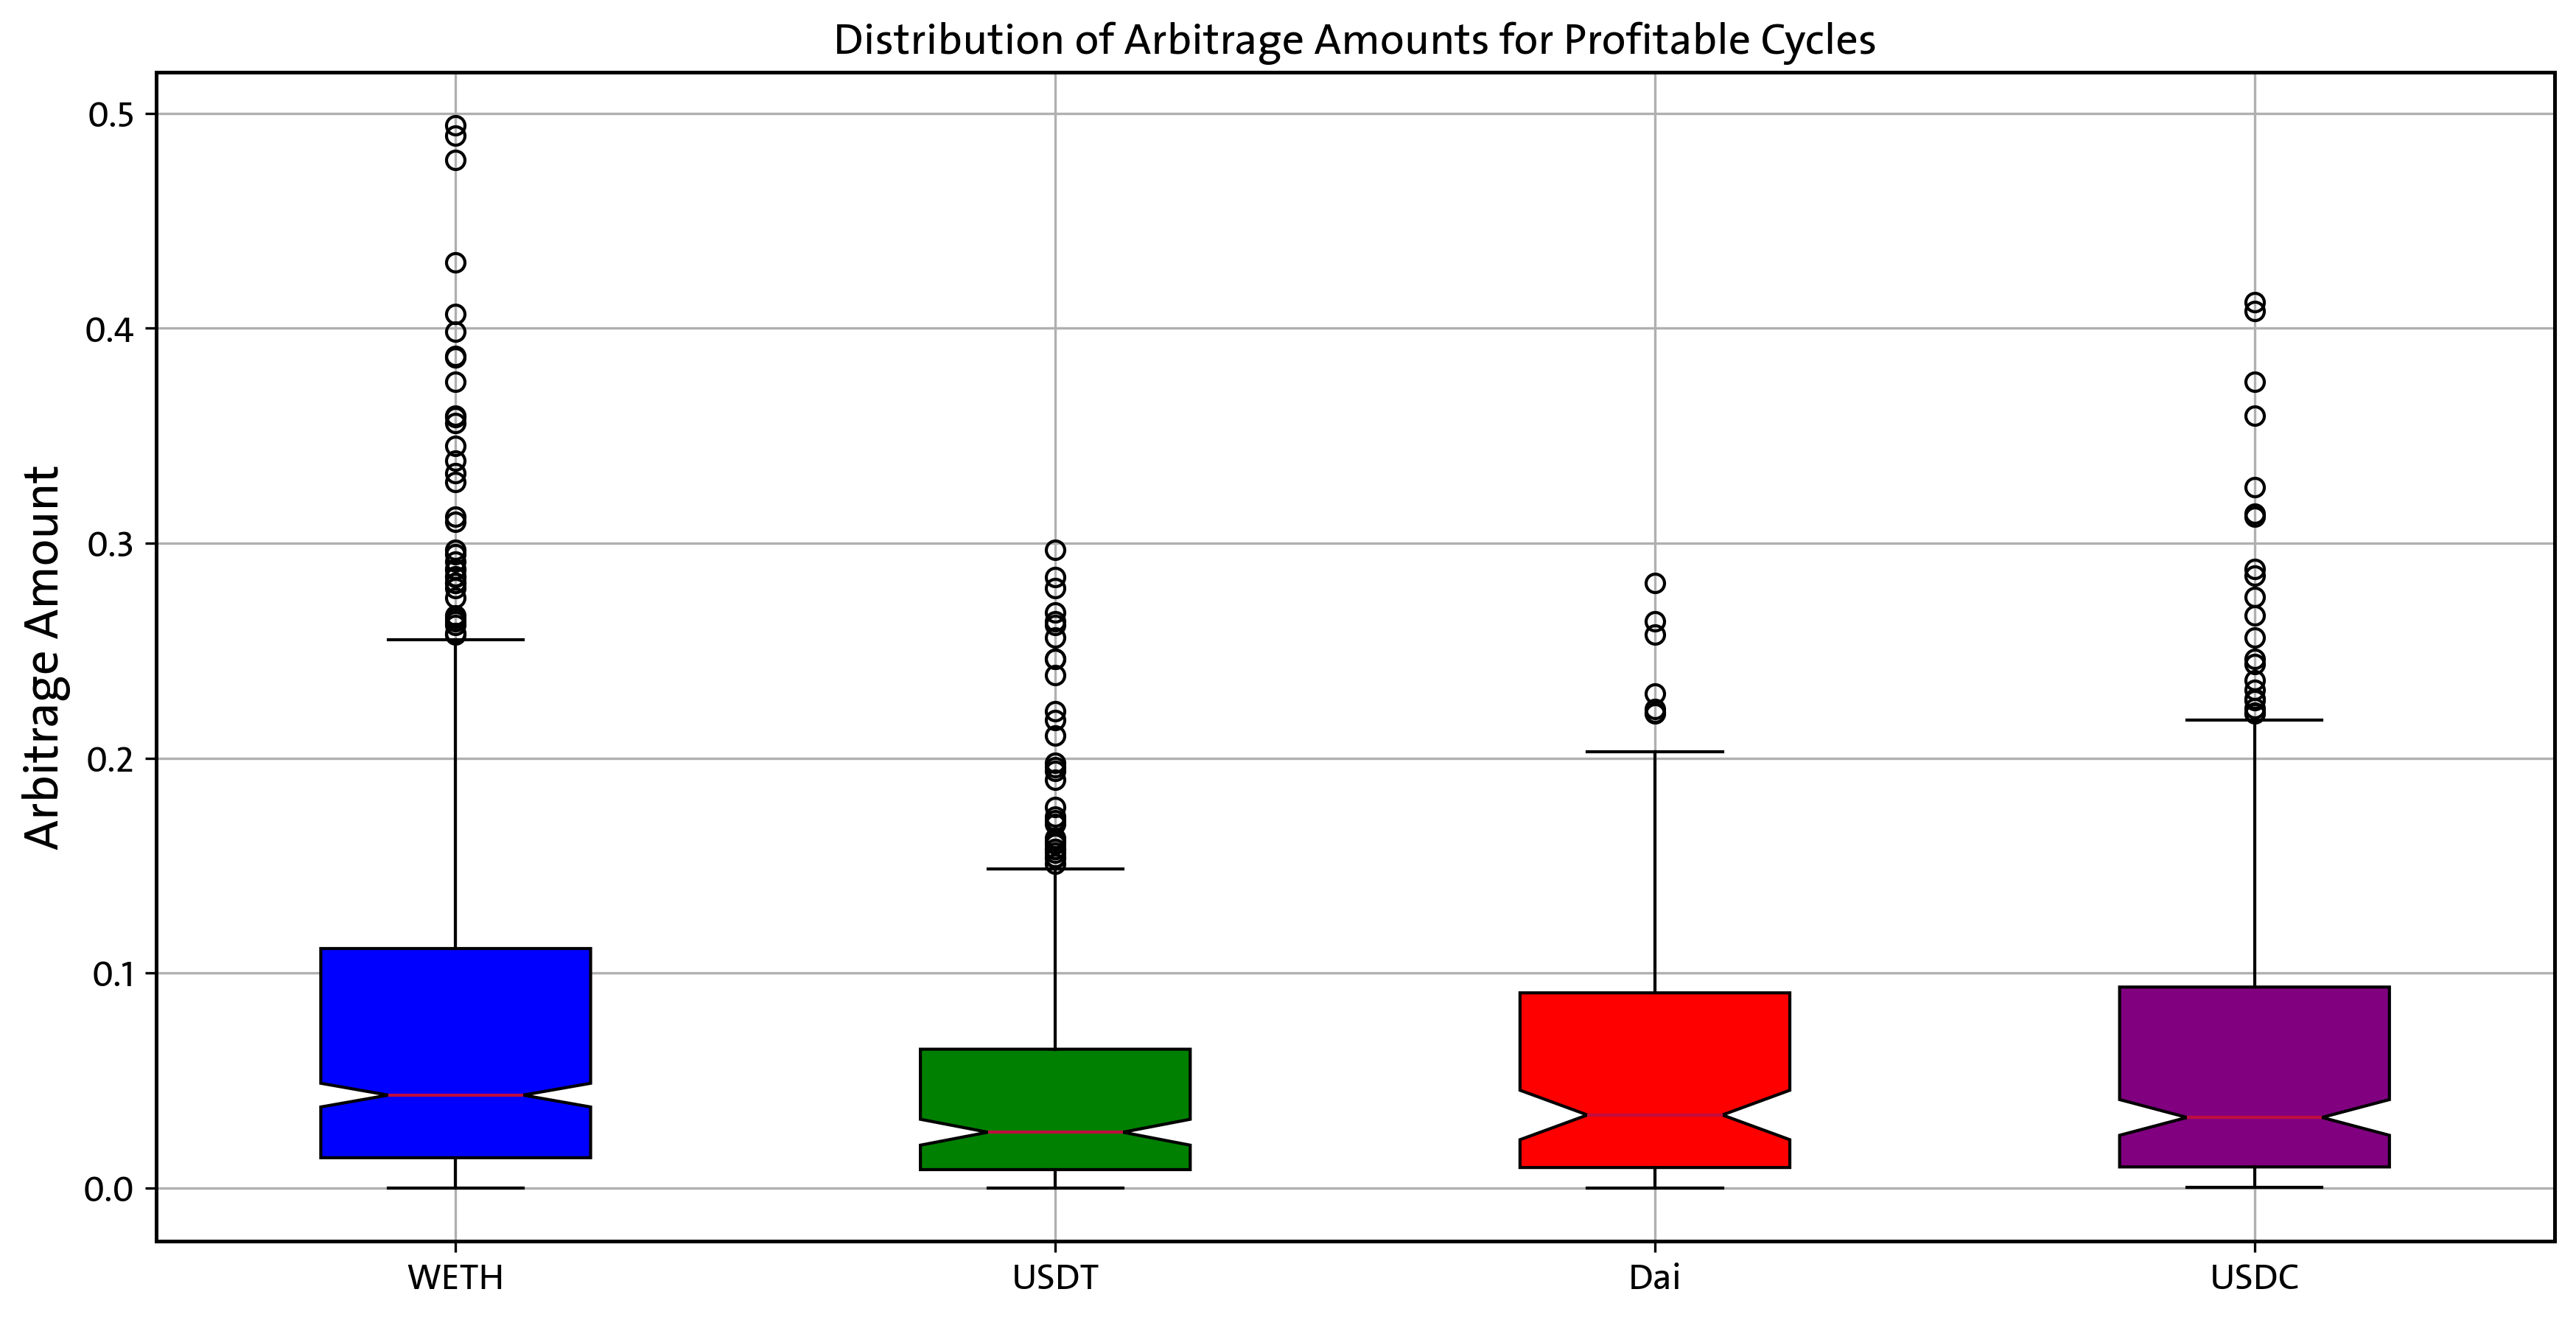

In [168]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,7),dpi =300)
arbitrage_amounts0 = [cycle['arbitrage_amount'] for cycle in filtered_profitable_cycles0]
arbitrage_amounts1 = [cycle['arbitrage_amount'] for cycle in filtered_profitable_cycles1]
arbitrage_amounts2 = [cycle['arbitrage_amount'] for cycle in filtered_profitable_cycles2]
arbitrage_amounts3 = [cycle['arbitrage_amount'] for cycle in filtered_profitable_cycles3]

# 绘制四个不同颜色的箱型图
#plt.figure(figsize=(20, 15))
boxplots = plt.boxplot([arbitrage_amounts0, arbitrage_amounts1, arbitrage_amounts2, arbitrage_amounts3], 
                       vert=True, patch_artist=True, notch=True,
                       labels=['WETH', 'USDT', 'Dai', 'USDC'])

# 设置不同的颜色
colors = ['blue', 'green', 'red', 'purple']
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of Arbitrage Amounts for Profitable Cycles')
plt.ylabel('Arbitrage Amount')
plt.grid(True)

# 显示图形
plt.show()
fig.savefig('Length3_Distribution.pdf',dpi=300,bbox_inches='tight',facecolor='w')

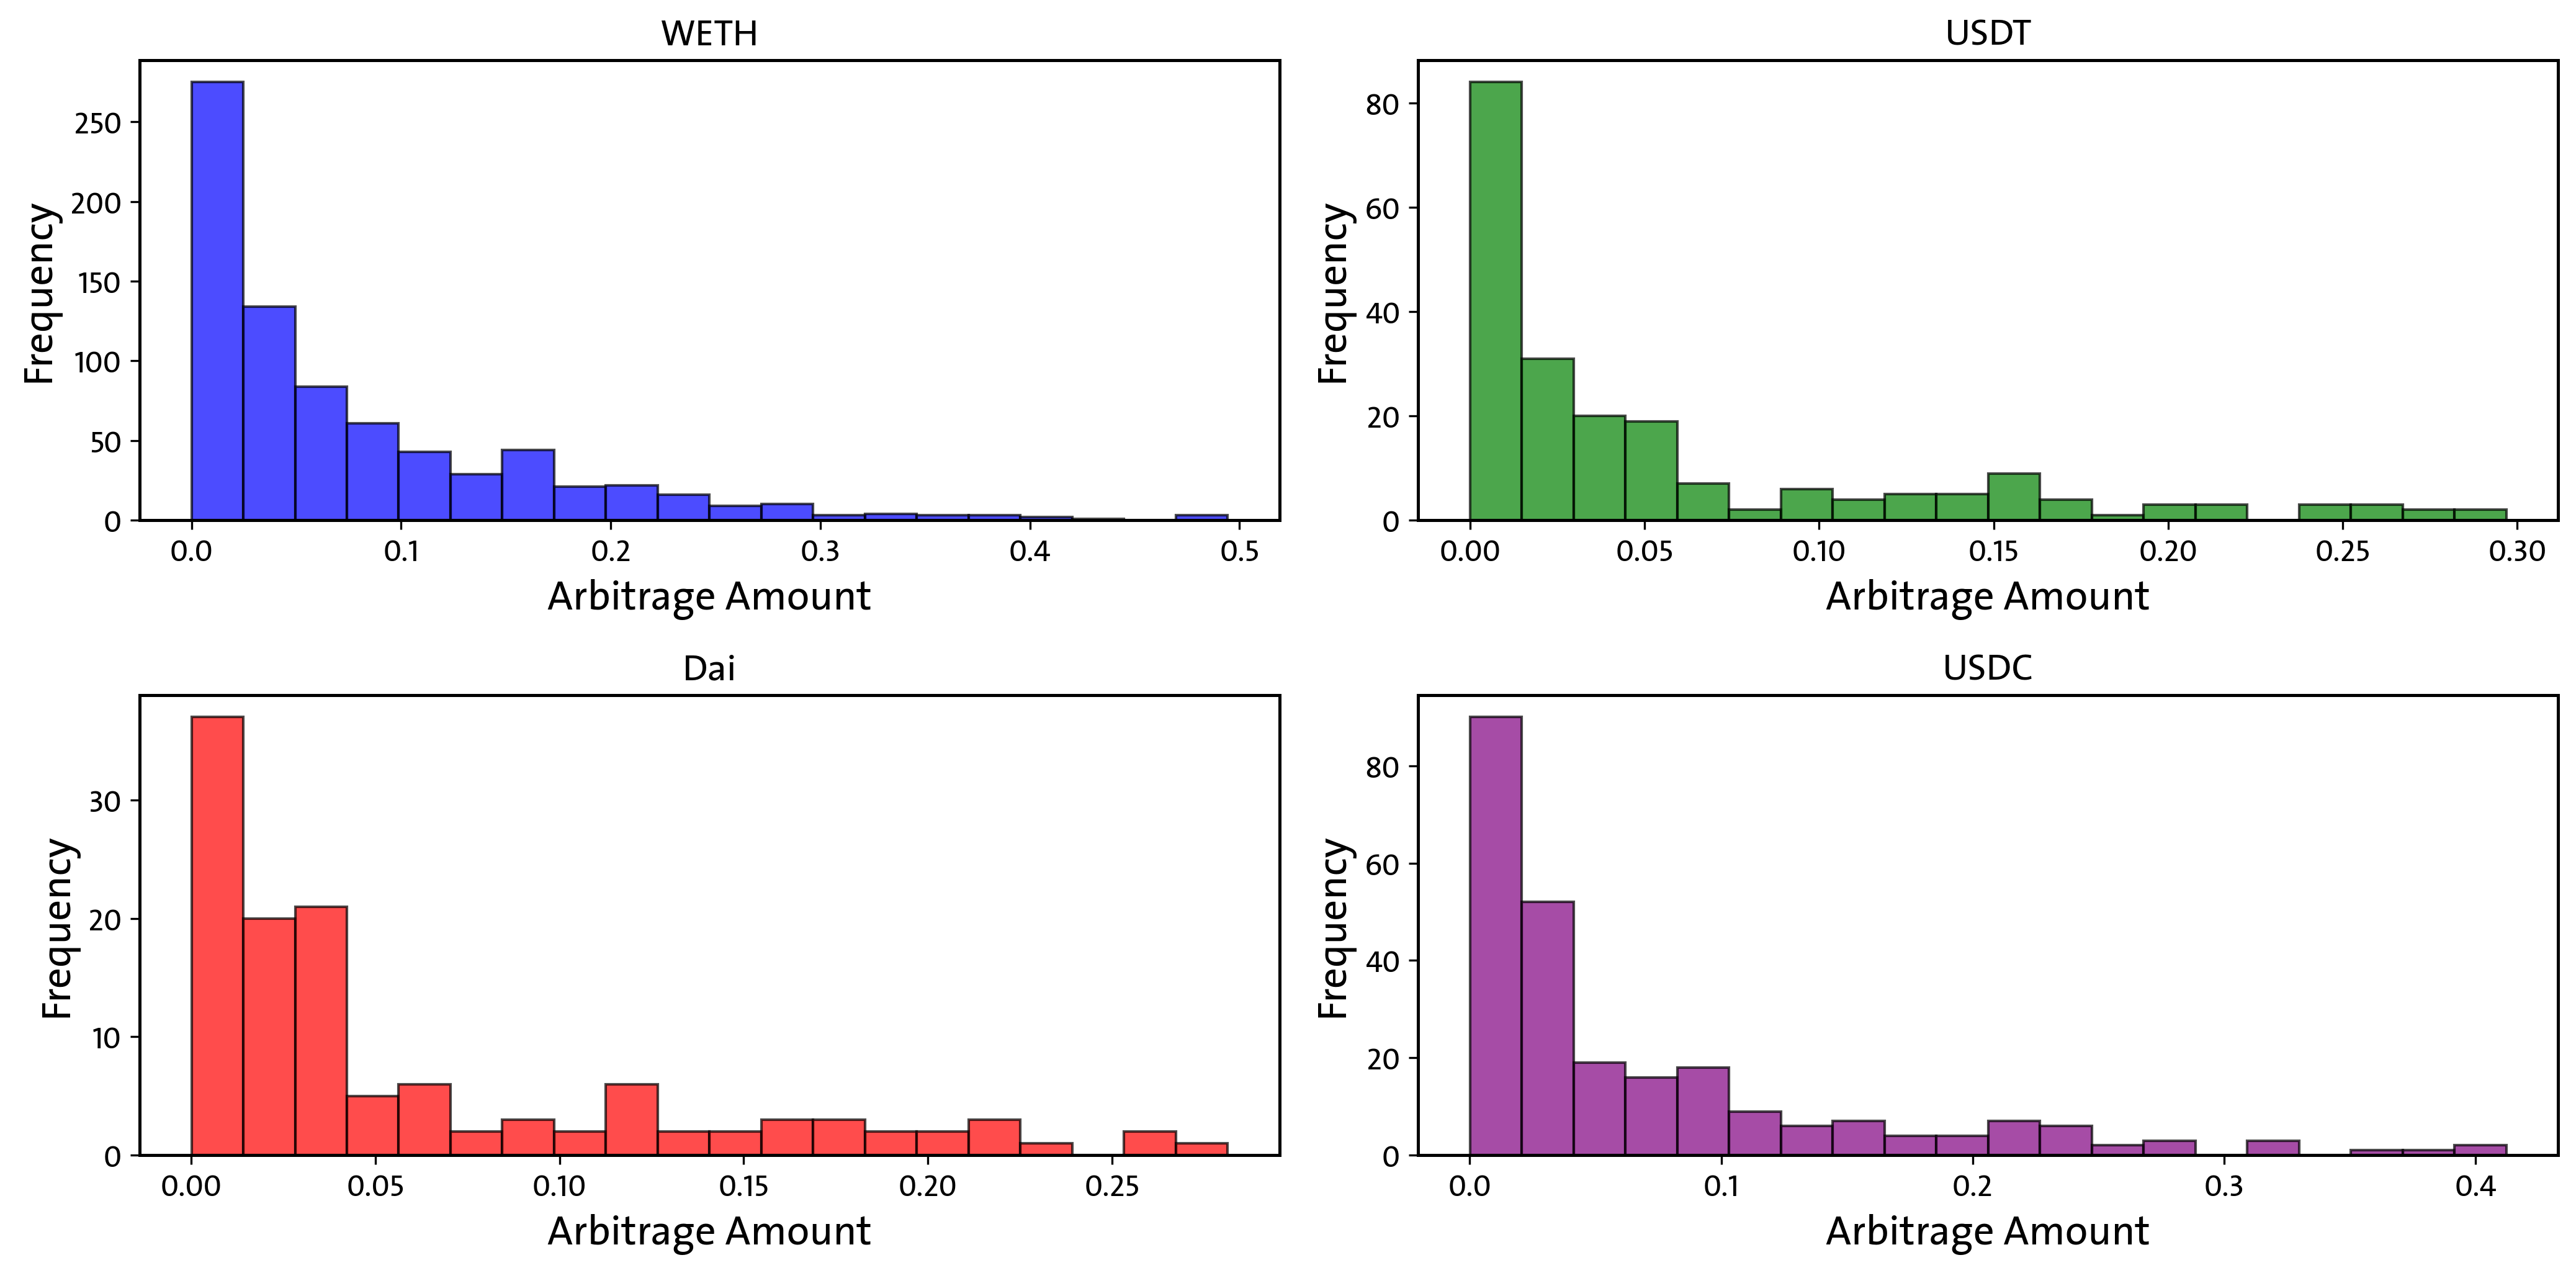

In [169]:
# 创建2x2子图来绘制四个直方图fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,7),dpi =300)
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

# 直方图参数设置
bins = 20  # 为了更好地展示分布，减少bins数量
alpha = 0.7
edgecolor = 'black'

# 绘制每个直方图
axs[0, 0].hist(arbitrage_amounts0, bins=bins, alpha=alpha, color='blue', edgecolor=edgecolor)
axs[0, 0].set_title('WETH')
axs[0, 0].set_xlabel('Arbitrage Amount')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(arbitrage_amounts1, bins=bins, alpha=alpha, color='green', edgecolor=edgecolor)
axs[0, 1].set_title('USDT')
axs[0, 1].set_xlabel('Arbitrage Amount')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(arbitrage_amounts2, bins=bins, alpha=alpha, color='red', edgecolor=edgecolor)
axs[1, 0].set_title('Dai')
axs[1, 0].set_xlabel('Arbitrage Amount')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(arbitrage_amounts3, bins=bins, alpha=alpha, color='purple', edgecolor=edgecolor)
axs[1, 1].set_title('USDC')
axs[1, 1].set_xlabel('Arbitrage Amount')
axs[1, 1].set_ylabel('Frequency')

# 调整布局
plt.tight_layout()
plt.show()
fig.savefig('Length3_Histogram.pdf',dpi=300,bbox_inches='tight',facecolor='w')

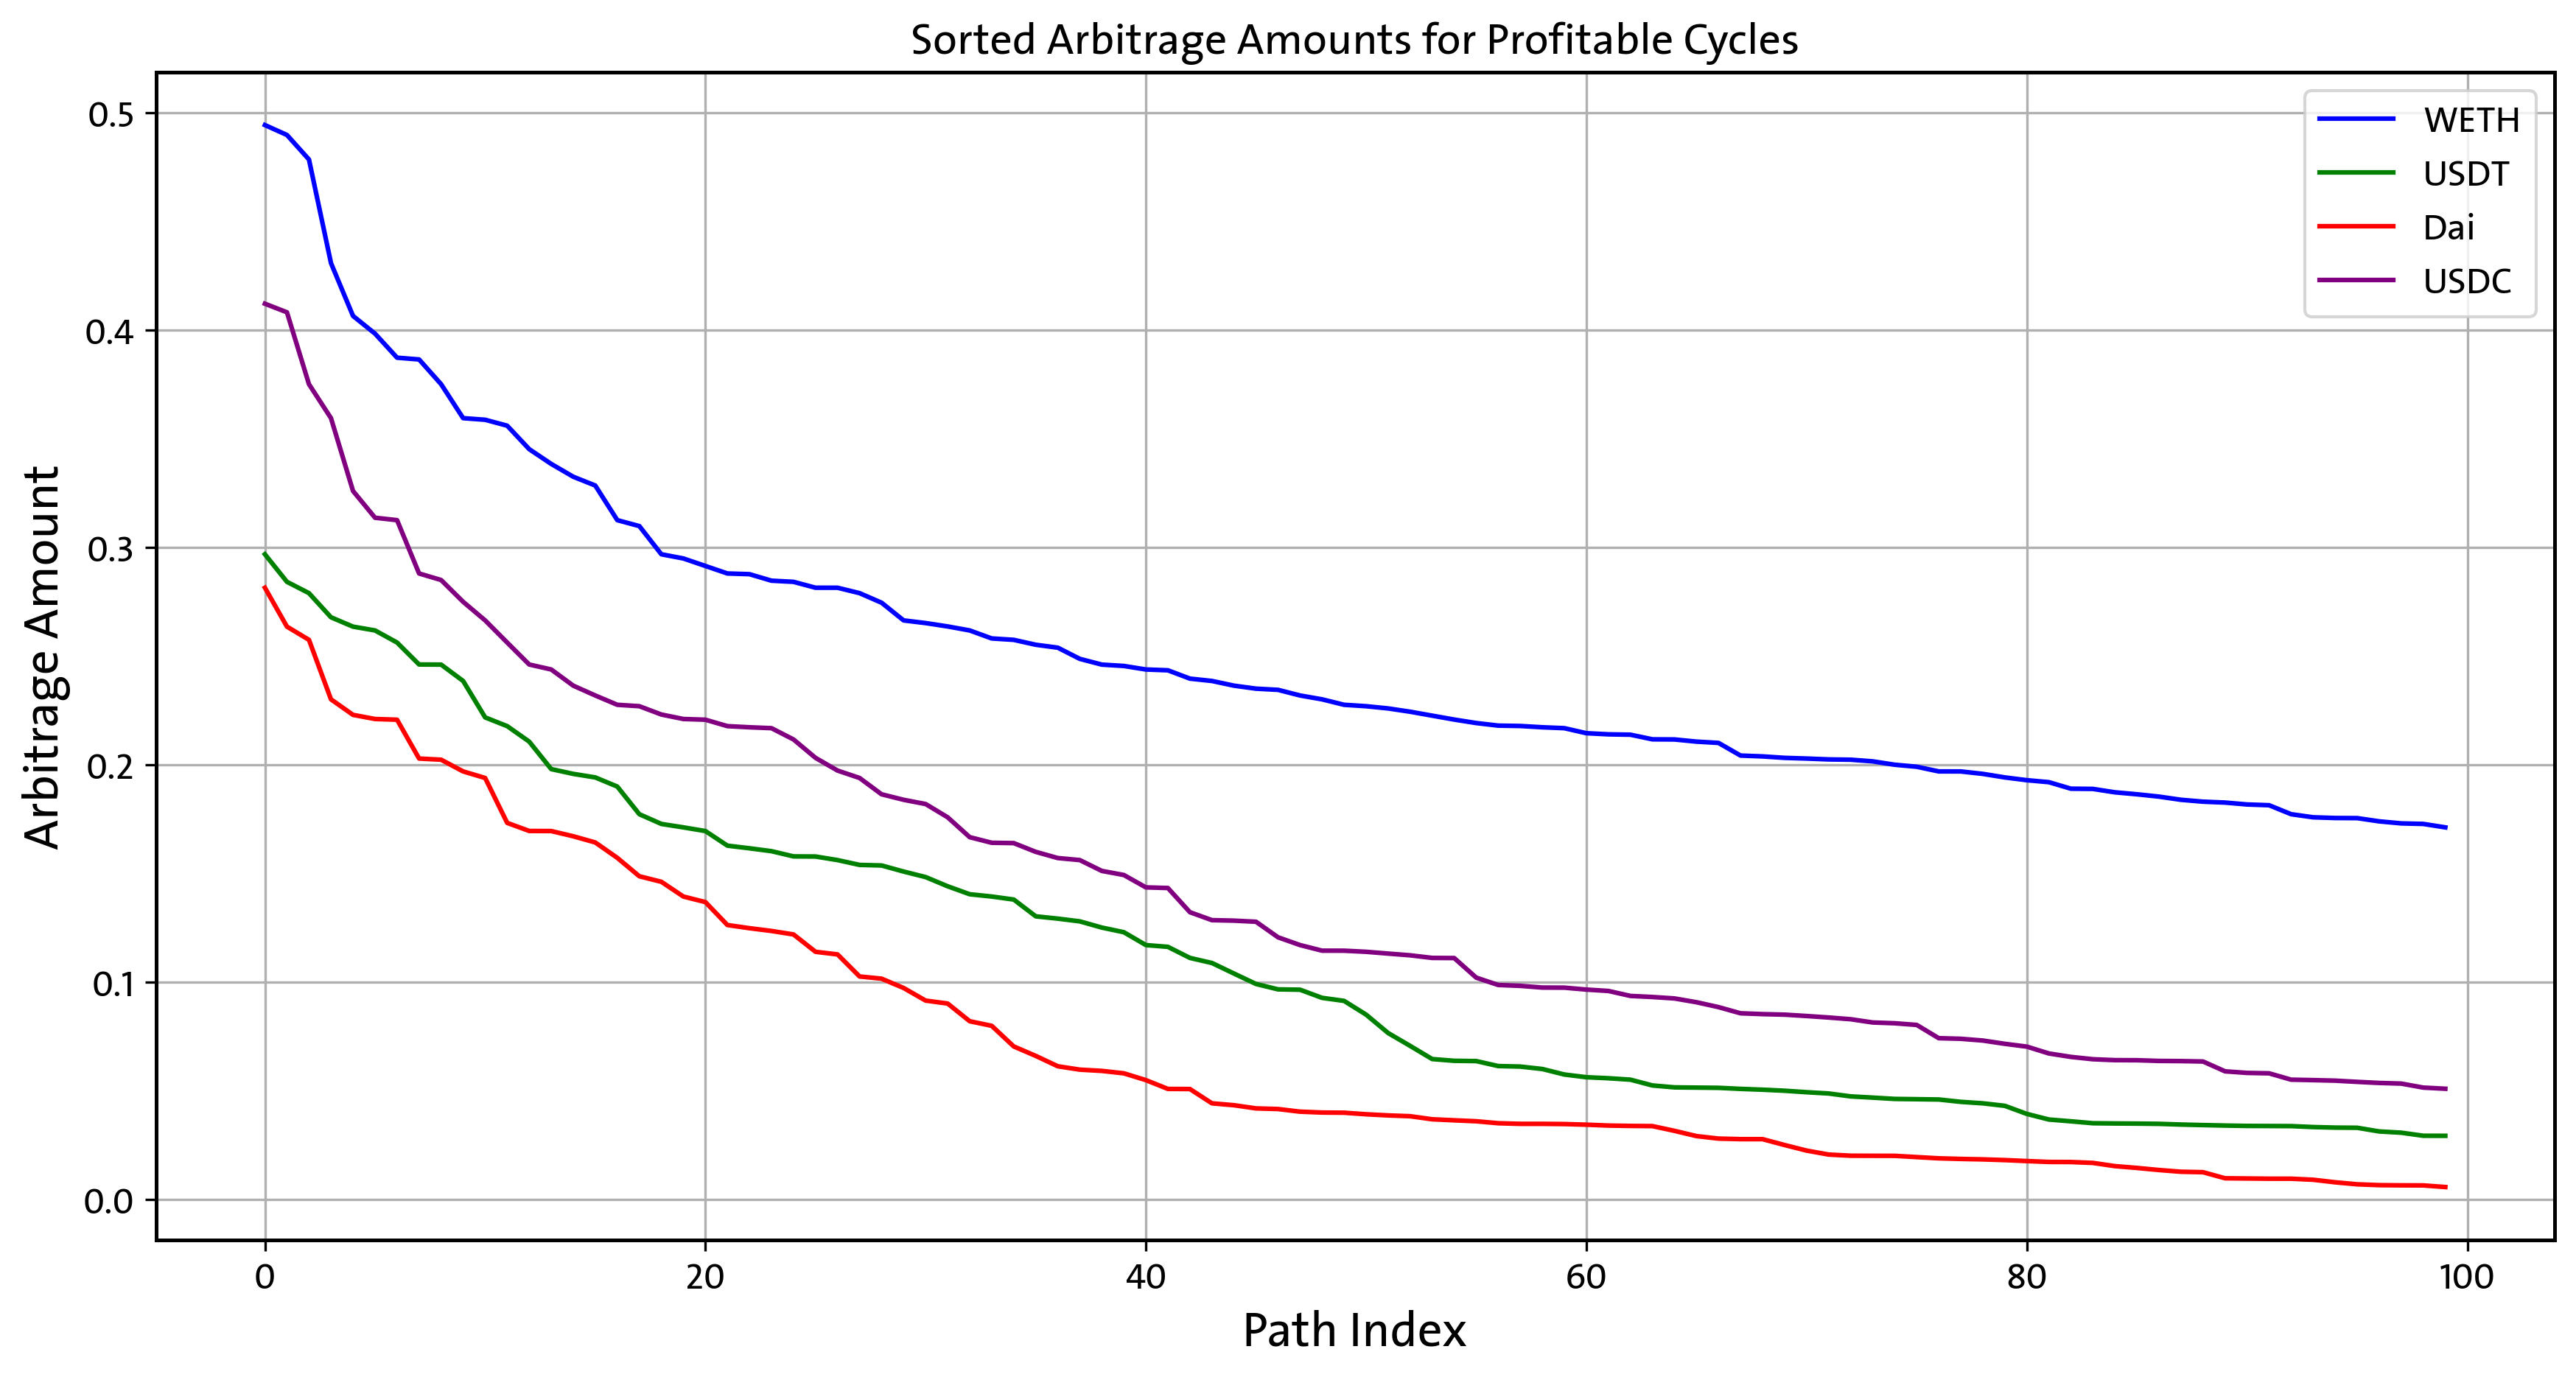

In [170]:
sorted_filtered_profitable_cycles0 = sorted(filtered_profitable_cycles0, key=lambda x: x['arbitrage_amount'], reverse=True)
sorted_filtered_profitable_cycles1 = sorted(filtered_profitable_cycles1, key=lambda x: x['arbitrage_amount'], reverse=True)
sorted_filtered_profitable_cycles2 = sorted(filtered_profitable_cycles2, key=lambda x: x['arbitrage_amount'], reverse=True)
sorted_filtered_profitable_cycles3 = sorted(filtered_profitable_cycles3, key=lambda x: x['arbitrage_amount'], reverse=True)
arbitrage_amounts0 = [cycle['arbitrage_amount'] for cycle in sorted_filtered_profitable_cycles0]
arbitrage_amounts1 = [cycle['arbitrage_amount'] for cycle in sorted_filtered_profitable_cycles1]
arbitrage_amounts2 = [cycle['arbitrage_amount'] for cycle in sorted_filtered_profitable_cycles2]
arbitrage_amounts3 = [cycle['arbitrage_amount'] for cycle in sorted_filtered_profitable_cycles3]
# 绘制折线图
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,7),dpi =300)
plt.plot(arbitrage_amounts0[:100], label='WETH', color='blue', marker=',')
plt.plot(arbitrage_amounts1[:100], label='USDT', color='green', marker=',')
plt.plot(arbitrage_amounts2[:100], label='Dai', color='red', marker=',')
plt.plot(arbitrage_amounts3[:100], label='USDC', color='purple', marker=',')

plt.title('Sorted Arbitrage Amounts for Profitable Cycles')
plt.xlabel('Path Index')
plt.ylabel('Arbitrage Amount')
plt.legend()
plt.grid(True)


plt.show()
fig.savefig('Length3_Sorted.pdf',dpi=300,bbox_inches='tight',facecolor='w')

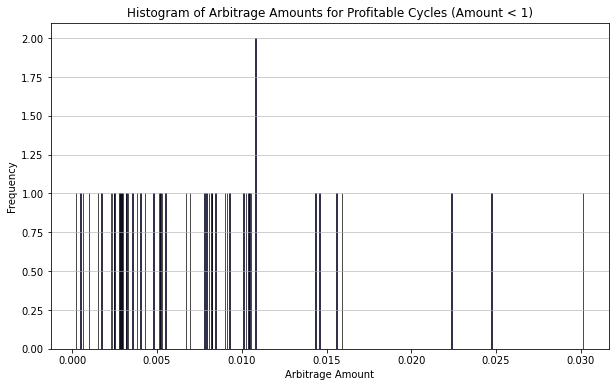

In [42]:
# 提取arbitrage_amount数据用于直方图
arbitrage_amounts = [cycle['arbitrage_amount'] for cycle in filtered_profitable_cycles]

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(arbitrage_amounts, bins=1000, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Arbitrage Amounts for Profitable Cycles (Amount < 1)')
plt.xlabel('Arbitrage Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# 显示图形
plt.show()

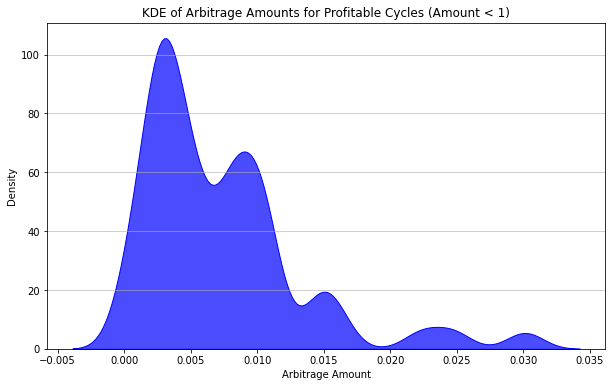

In [43]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.kdeplot(arbitrage_amounts, fill=True, color="blue", alpha=0.7,bw_adjust=0.5)
plt.title('KDE of Arbitrage Amounts for Profitable Cycles (Amount < 1)')
plt.xlabel('Arbitrage Amount')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# 显示图形
plt.show()

In [ ]:
# 初始化存储结果的字典
average_arbitrage_amounts = {}
profitable_cycle_counts = {}
arbitrage_amounts_by_length = {}

for length in range(4,10):
    processed_cycles = process_cycles_with_slippage_and_reserve(G_sample, cycles_by_length, length=length)
    
    # 筛选出所有环路计算平均值
    arbitrage_amounts = [cycle['arbitrage_amount'] for cycle in processed_cycles[length] if cycle['arbitrage_amount'] is not None]
    
    # 对arbitrage_amounts进行排序
    sorted_amounts = sorted(arbitrage_amounts)
    
    # 计算要去除的数据数量（10%）
    remove_count = int(len(sorted_amounts) * 0.2)
    
    # 去除最大和最小的10%数据
    trimmed_amounts = sorted_amounts[remove_count:-remove_count]
    
    # 计算去除极端值后的平均值
    average_arbitrage_amounts[length] = np.mean(trimmed_amounts) if trimmed_amounts else 0
    
    # 计算可套利环路数量
    profitable_cycle_counts[length] = len([amount for amount in trimmed_amounts if amount > 0])
    
    # 存储trimmed_amounts以便后续画图
    arbitrage_amounts_by_length[length] = trimmed_amounts

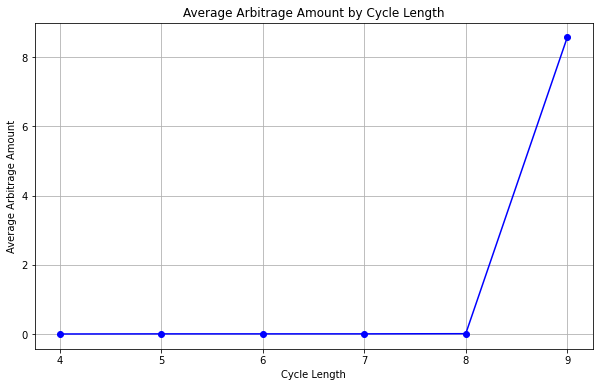

In [48]:
# 绘制平均套利金额图
plt.figure(figsize=(10, 6))
plt.plot(average_arbitrage_amounts.keys(), average_arbitrage_amounts.values(), marker='o', linestyle='-', color='blue')
plt.title('Average Arbitrage Amount by Cycle Length')
plt.xlabel('Cycle Length')
plt.ylabel('Average Arbitrage Amount')
plt.xticks([4, 5, 6, 7, 8, 9])  # 显式设置x轴的刻度
plt.grid(True)
plt.show()

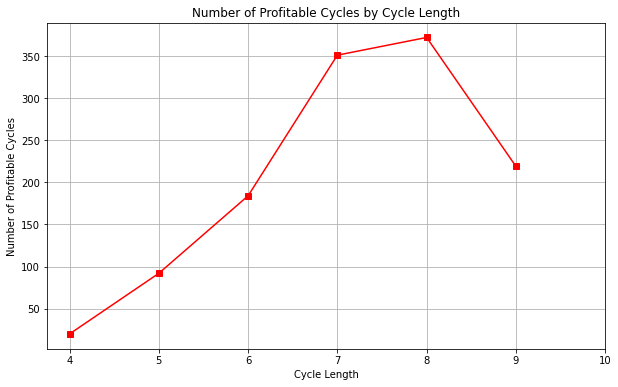

In [49]:
# 绘制可套利环路数量图
plt.figure(figsize=(10, 6))
plt.plot(profitable_cycle_counts.keys(), profitable_cycle_counts.values(), marker='s', linestyle='-', color='red')
plt.title('Number of Profitable Cycles by Cycle Length')
plt.xlabel('Cycle Length')
plt.ylabel('Number of Profitable Cycles')
plt.xticks([4, 5, 6, 7, 8, 9,10])  # 显式设置x轴的刻度
plt.grid(True)
plt.show()

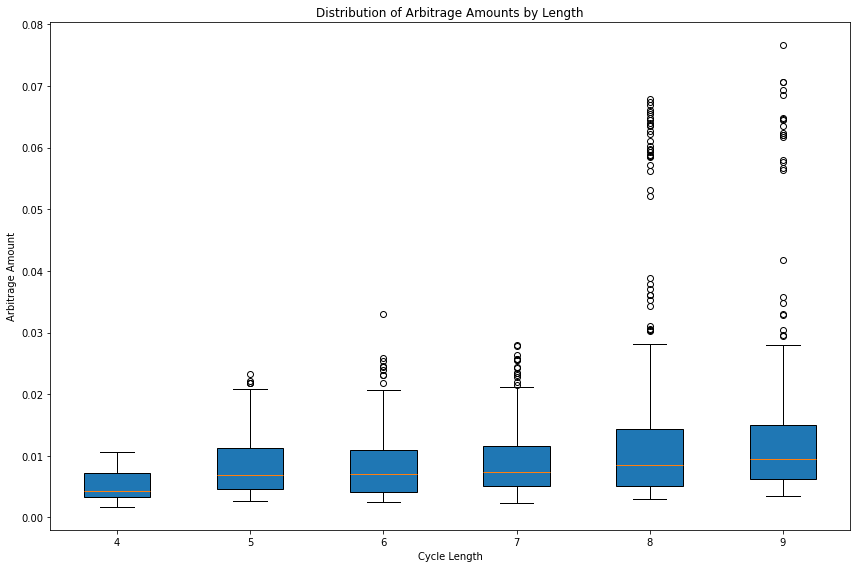

In [50]:
# 创建一个更大尺寸的图形
plt.figure(figsize=(12, 8))  # 调整这里的数字来改变图形的尺寸

# 筛选出套利金额小于1的数据
filtered_arbitrage_amounts = {
    length: [amount for amount in amounts if amount < 1] 
    for length, amounts in arbitrage_amounts_by_length.items()
}

# 绘制箱型图
plt.boxplot(filtered_arbitrage_amounts.values(), labels=filtered_arbitrage_amounts.keys(), patch_artist=True)
plt.title('Distribution of Arbitrage Amounts by Length')
plt.xlabel('Cycle Length')
plt.ylabel('Arbitrage Amount')

plt.tight_layout()  # 确保子图不会相互重叠
plt.show()


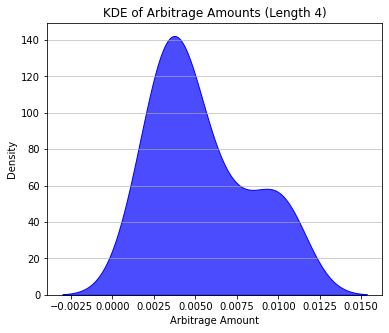

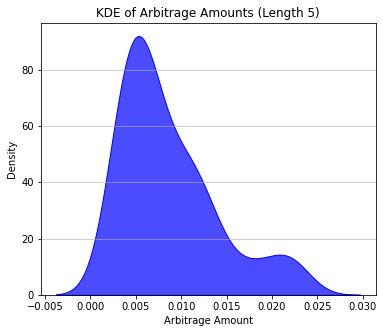

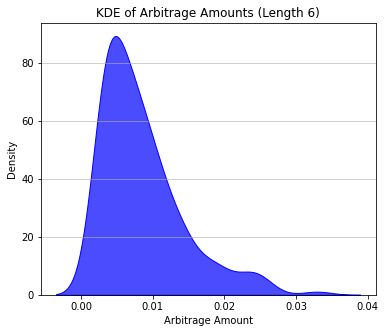

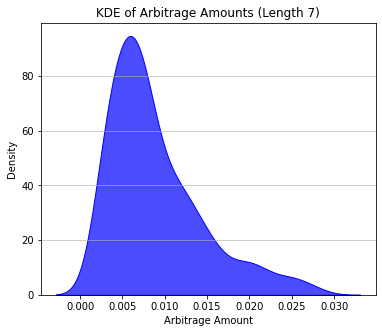

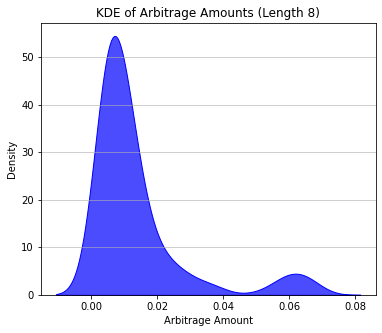

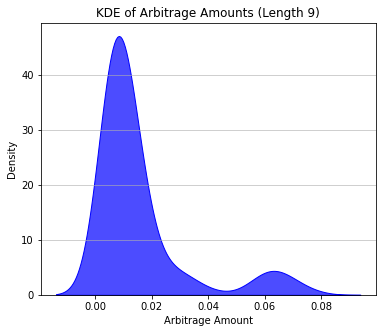

In [51]:
# 对于每个环路长度绘制KDE图
for length, amounts in filtered_arbitrage_amounts.items():
    plt.figure(figsize=(6, 5))
    sns.kdeplot(amounts, fill=True, color="blue", alpha=0.7)
    plt.title(f'KDE of Arbitrage Amounts (Length {length})')
    plt.xlabel('Arbitrage Amount')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [ ]:
# Use start_token to find all real loops, sorted by length
cycles_by_length = find_cycles_classified_by_length(G_sample, start_token, max_depth=6)

# Extract detailed information for a collection of loops of each length(except amount)
details_by_length = {}  # Used to store details by length

for cycle_length, cycles in cycles_by_length.items():
    details_by_length[cycle_length] = extract_path_details(G_sample, cycles)

# Number of loops found by the output and examples
num_true_cycles_found = sum(len(cycles) for cycles in cycles_by_length.values())
print(f"Total number of true cycles found: {num_true_cycles_found}")

# If you need to output the example details, you can select a length and print it.
example_length = next(iter(details_by_length.keys()))
print(f"Example details for cycles of length {example_length}:")
print(details_by_length[example_length][:1])

In [ ]:
# Example
if 5 in details_by_length:
    cycles_length_6 = details_by_length[6]
    
    for cycle_detail in cycles_length_6:
        path = cycle_detail['path']
        equivalent_start_token_reserve = calculate_equivalent_start_token_reserve(G_sample, path)
        arbitrage_amount = calculate_arbitrage_amount(G_sample, path)

        cycle_detail['equivalent_start_token_reserve'] = equivalent_start_token_reserve
        cycle_detail['arbitrage_amount'] = arbitrage_amount
    
    print("Example details for a cycle of length 6:")
    print(cycles_length_6[0])
else:
    print("No cycles of length 6 were found.")

In [55]:
# Comparing running time after optimization
start_token = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
max_depths = [4, 5, 6, 7, 8, 9, 10]
for depth in max_depths:
    start_time = time.time()
    find_cycles_classified_by_length(G_sample, start_token, max_depth=depth)
    normal_duration = time.time() - start_time

    start_time = time.time()
    find_cycles_classified_by_length_optimized(G_sample, start_token, max_depth=depth)
    optimized_duration = time.time() - start_time

    print(f"Max Depth: {depth}, Normal: {normal_duration:.4f}s, Optimized: {optimized_duration:.4f}s")

Max Depth: 4, Normal: 0.0058s, Optimized: 0.0348s
Max Depth: 5, Normal: 0.0124s, Optimized: 0.0321s
Max Depth: 6, Normal: 0.0095s, Optimized: 0.0224s
Max Depth: 7, Normal: 0.0132s, Optimized: 0.0267s
Max Depth: 8, Normal: 0.0150s, Optimized: 0.0293s
Max Depth: 9, Normal: 0.0154s, Optimized: 0.0301s
Max Depth: 10, Normal: 0.0156s, Optimized: 0.0309s


In [53]:
def find_cycles_classified_by_length_optimized(G: nx.DiGraph, start_node: str, max_depth=10) -> dict:
    """
    Find all true cycles starting and ending with the given node in a directed graph,
    optimized with graph characteristics and pruning strategy.

    :param G: Directed graph focused on the largest SCC for optimization.
    :param start_node: Node to start and end cycles.
    :param max_depth: Maximum depth to search to prevent deep recursion.
    :return: Dictionary with keys as cycle lengths and values as lists of cycles of that length.
    """
    cycles_by_length = {}

    def dfs(current_node, visited, path, depth):
        if depth > max_depth:
            return

        path.append(current_node)

        if len(path) > 2 and path[-1] == start_node:  # Found a cycle
            cycle = tuple(path)
            cycle_length = len(cycle) - 1  # Adjust for accurate cycle length
            cycles_by_length.setdefault(cycle_length, []).append(cycle)
            path.pop()
            return

        visited.add(current_node)
        
        for neighbor in G.successors(current_node):
            if neighbor not in visited or neighbor == start_node:
                dfs(neighbor, visited.copy(), path.copy(), depth + 1)
        
        visited.remove(current_node)
        path.pop()

    # Preprocess: Focus on the largest SCC if start_node is part of it
    sccs = list(nx.strongly_connected_components(G))
    largest_scc = max(sccs, key=len)
    if start_node in largest_scc:
        G_scc = G.subgraph(largest_scc).copy()
        dfs(start_node, set(), [], 1)
    else:
        print("Start node is not in the largest SCC, skipping search.")

    return cycles_by_length


In [151]:
# 分析图的基本特性
num_nodes = G_sample.number_of_nodes()
num_edges = G_sample.number_of_edges()
density = nx.density(G_sample)
strongly_connected_components = list(nx.strongly_connected_components(G_sample))
largest_scc = max(strongly_connected_components, key=len)  # 最大强连通分量
average_degree = sum(dict(G_sample.degree()).values()) / float(num_nodes)

# 输出结果
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Density: {density:.4f}")
print(f"Number of Strongly Connected Components: {len(strongly_connected_components)}")
print(f"Largest Strongly Connected Component Size: {len(largest_scc)}")
print(f"Average Degree: {average_degree:.2f}")

Number of Nodes: 24408
Number of Edges: 50432
Density: 0.0001
Number of Strongly Connected Components: 37
Largest Strongly Connected Component Size: 24330
Average Degree: 4.13


In [161]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
font_dirs = ['Fonts'] #修改为你存放上面这个字体文件夹的地址
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

ModuleNotFoundError: No module named 'plotly_uzh_template'

In [1]:
def format_path_data(G, cycles, path_length):
    """
    Format the paths of a given length from cycles_by_length, extracting edges (token pairs)
    and their corresponding reserves pairs.

    :param G: Directed graph from which to extract path details.
    :param cycles: List of cycles (paths) of a specific length from cycles_by_length.
    :param path_length: The length of the paths in cycles to be formatted.
    :return: A list containing the formatted details for each path.
    """
    formatted_paths = []

    for cycle in cycles:
        if len(cycle) == path_length:
            edges_list = []
            reserves_list = []

            for i in range(len(cycle)):
                start_node = cycle[i]
                end_node = cycle[(i + 1) % path_length]  # Ensure wrapping to the start

                edge_data = G.get_edge_data(start_node, end_node)
                edges_list.append((start_node, end_node))

                # Reserve for the current edge and the next edge, considering wrapping
                current_reserve = edge_data['reserve']
                next_edge_data = G.get_edge_data(end_node, cycle[(i + 2) % path_length])
                next_reserve = next_edge_data['reserve'] if next_edge_data else 0  # Handle potential missing edge gracefully

                reserves_list.append((current_reserve, next_reserve))

            formatted_paths.append({
                'edges': edges_list,
                'reserves': reserves_list,
            })

    return formatted_paths


In [3]:
formatted_data = format_path_data(G_sample, cycles_by_length[4], 4)

NameError: name 'G_sample' is not defined